# Example LFPy MEG
Demonstrate magnetic field predictions in a single point from current dipole moment with LFPy

In [1]:
%matplotlib inline

In [2]:
## if running on mybinder or similar, uncomment and run the two following lines to install LFPy. 
## Then restart the kernel.
#!conda install mpi4py -y
#!pip install -e git+https://github.com/LFPy/LFPy.git@master#egg=LFPy

In [3]:
import LFPy, os, numpy as np, matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from lfpykit import CurrentDipoleMoment
from lfpykit.eegmegcalc import MEG

In [4]:
# create LFPy.Cell object
cell = LFPy.Cell(morphology=os.path.join(LFPy.__path__[0], 'test',
                                         'ball_and_sticks.hoc'),
                 passive=True)
cell.set_pos(0., 0., 0.)

# create single synaptic stimuli
syn = LFPy.Synapse(cell, idx=cell.totnsegs-1, syntype='ExpSyn', weight=0.01, tau=5,
                   record_current=True)
syn.set_spike_times_w_netstim()

# create current dipole moment probe
current_dipole_moment = CurrentDipoleMoment(cell=cell)

# simulate, record current dipole moment
cell.simulate(probes=[current_dipole_moment])

In [5]:
# Compute the dipole location as an average of segment locations
# weighted by membrane area:
dipole_location = (cell.area * np.c_[cell.x.mean(axis=-1), 
                                     cell.y.mean(axis=-1), 
                                     cell.z.mean(axis=-1)].T
                   / cell.area.sum()).sum(axis=1)

# Define sensor site, instantiate MEG object, get transformation matrix
sensor_locations = np.array([[2E2, 0, 1E3]])
meg = MEG(sensor_locations)
M = meg.get_transformation_matrix(dipole_location)

# compute the magnetic signal in a single sensor location:
H = M @ current_dipole_moment.data

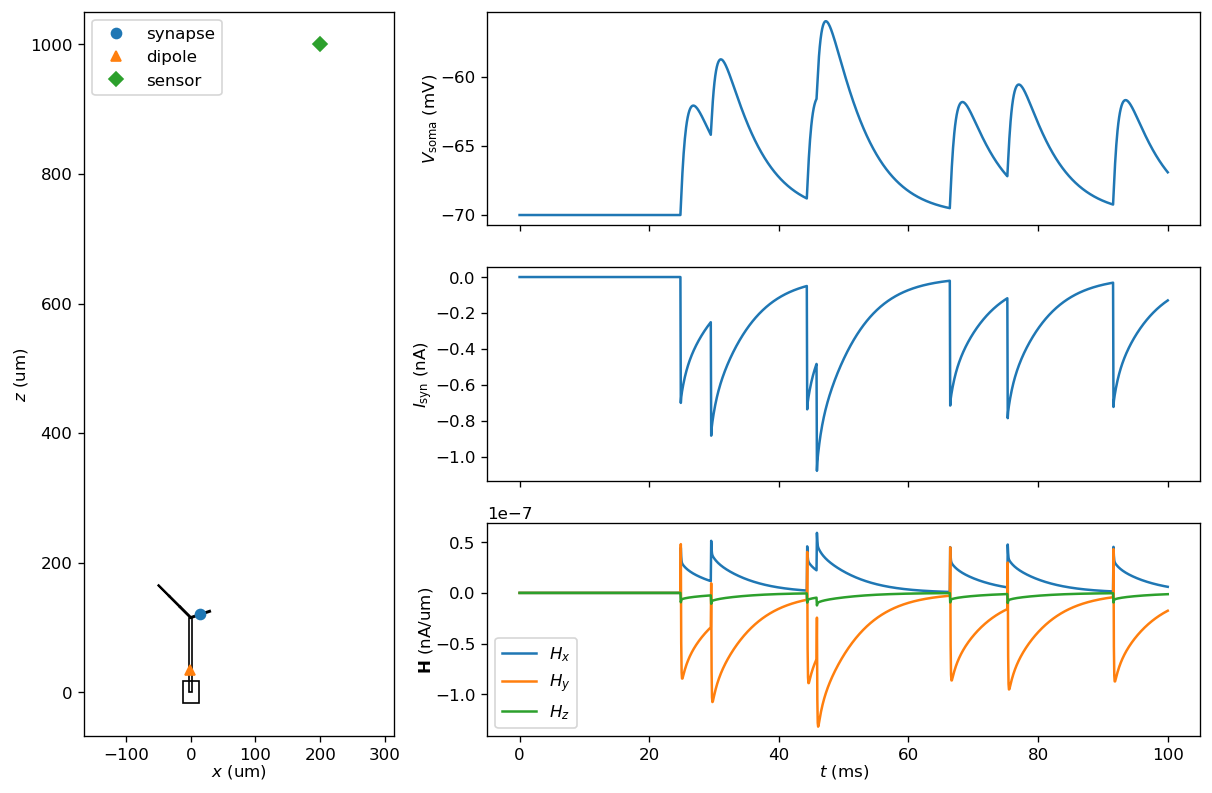

In [6]:
# plot output
fig = plt.figure(figsize=(12, 8), dpi=120)
gs = GridSpec(3, 3, wspace=0.3)

# cell setup and sensor locations
ax0 = fig.add_subplot(gs[:, 0])
for xz in cell.get_idx_polygons(projection=('x', 'z')):
    ax0.add_patch(plt.Polygon(np.stack(xz).T, ec='k', fc='none', label='__nolabel__'))
ax0.plot(syn.x, syn.z, 'o', label='synapse')
ax0.plot(dipole_location[0], dipole_location[2], '^', label='dipole')
ax0.plot(sensor_locations[0, 0], sensor_locations[0, 2], 'D', label='sensor')
ax0.axis(ax0.axis('equal'))
ax0.legend()
ax0.set_xlabel('$x$ (um)', labelpad=0)
ax0.set_ylabel('$z$ (um)', labelpad=0)

# somatic voltage
ax1 = fig.add_subplot(gs[0, 1:])
ax1.plot(cell.tvec, cell.somav)
ax1.set_ylabel(r'$V_\mathrm{soma}$ (mV)', labelpad=0)
ax1.set_xticklabels([])

# synapse current
ax2 = fig.add_subplot(gs[1, 1:])
ax2.plot(cell.tvec, syn.i)
ax2.set_ylabel(r'$I_\mathrm{syn}$ (nA)', labelpad=0)
ax2.set_xticklabels([])

# magnetic field components
ax3 = fig.add_subplot(gs[2, 1:])
ax3.plot(cell.tvec, H[0].T)
ax3.set_ylabel(r'$\mathbf{H}$ (nA/um)', labelpad=0)
ax3.set_xlabel('$t$ (ms)', labelpad=0)
ax3.legend(['$H_x$', '$H_y$', '$H_z$'])